In [1]:
#env: sex_diff
import pandas as pd
from itertools import combinations
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.stats import permutation_test
from sklearn.metrics.pairwise import cosine_similarity
from scipy.interpolate import make_interp_spline
import os
import pickle
import matplotlib.pyplot as plt


# Sex fine-tuned Krakencoder eTIV

In [ ]:
def kraken_compare(ylim_min, bins, group_labels, fig_size):
    outer_folds = 100
    n_bins      = len(bins) - 1
    fusion_types = [
        ('FCs Only (Fusion FC)',  'fusionFC'),
        ('SCs (Fusion SC)', 'fusionSC'),
        ('FCs + SCs (Fusion)', 'fusion')
    ]

    base_dir = '/home/out_log/results_HCPdata_Kraken/newYA95/krakencoder500_sex0508/results1110/'
    fig, axes = plt.subplots(2, 2, figsize=fig_size)
    axes = axes.flatten()

    palette={'Logistic regression': 'palevioletred', 
            'Kernel Ridge': 'coral',
            'SVC': 'steelblue',
            'MLP': 'lightblue'} 

    handles = []
    labels = []

    for ax, (title, fusion_key) in zip(axes[:3], fusion_types):
        dfs = []

        # load four sex fine-tuned Krakencoder variants…
        for label, subdir in [
            ('Logistic regression', 'logistic'),
            ('Kernel Ridge', 'krr'),
            ('SVC','SVC'),
            ('MLP','mlp'),
        ]:
            path = os.path.join(
                base_dir,
                f'encoded_pred{fusion_key}[8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]_stratifiedCV_split0328_test30_addnewYA_trainoriYA0_downsampledtrain30_{subdir}.mat'

            )
            mat = scipy.io.loadmat(path, simplify_cells=True)
            arr = np.zeros((outer_folds, n_bins))
            for i in range(n_bins):
                key = f"{bins[i]}-{bins[i+1]}"
                arr[:, i] = mat[key]['test_accuracy'].ravel()
            df = pd.DataFrame(arr, columns=group_labels)
            df['model'] = label
            dfs.append(df)


        df_long = pd.concat(dfs, ignore_index=True).melt(
            id_vars='model', var_name='age_group', value_name='accuracy'
        )
        df_long['age_group'] = pd.Categorical(df_long['age_group'], categories=group_labels, ordered=True)
        sns.boxplot(
            x='age_group', y='accuracy',
            hue='model', data=df_long,
            dodge=True, ax=ax, palette = palette
        )

        x = np.arange(0, len(group_labels))
        med_df = (df_long.groupby(['model','age_group'], observed=False)['accuracy'].median().reset_index())
        x_smooth = np.linspace(0, len(group_labels)-1, 500)
        offset_map = {
            'Logistic regression': -0.1,
            'Kernel Ridge': 0.0,
            'SVC': +0.05,
            'MLP': +0.1,
        }
        for model_label, color in palette.items():
            dx = offset_map[model_label]
            m = med_df[med_df['model']==model_label]
            medians = m.set_index('age_group').reindex(group_labels)['accuracy'].values
            spl = make_interp_spline(x, medians, k=3)
            ax.plot(x_smooth+dx, spl(x_smooth), linewidth=0.9, color=color, label=None)    # add splines

        ax.set_title(title, fontsize=10)
        ax.set_xlabel("Age Range", fontsize=10)
        ax.set_ylabel("Accuracy", fontsize=10)
        ax.set_ylim(ylim_min, 1.05)
        ax.set_yticks(np.arange(ylim_min, 1.05 + 1e-8, 0.1))
        ax.tick_params(axis='x', rotation=45)
        if not handles:
            handles, labels = ax.get_legend_handles_labels()

        ax.get_legend().remove()
        axes[3].axis('off')

    fig.legend(handles, labels, title="Model", loc="lower center", bbox_to_anchor=(0.5, -0.02), ncol=len(labels), frameon=False)
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    fig.text(0.02, 0.98, "a)", fontsize=11, ha='right') 
    fig.text(0.52, 0.98, "b)", fontsize=11, ha='right') 
    fig.text(0.02, 0.5, "c)", fontsize=11, ha='right') 
    plt.show()

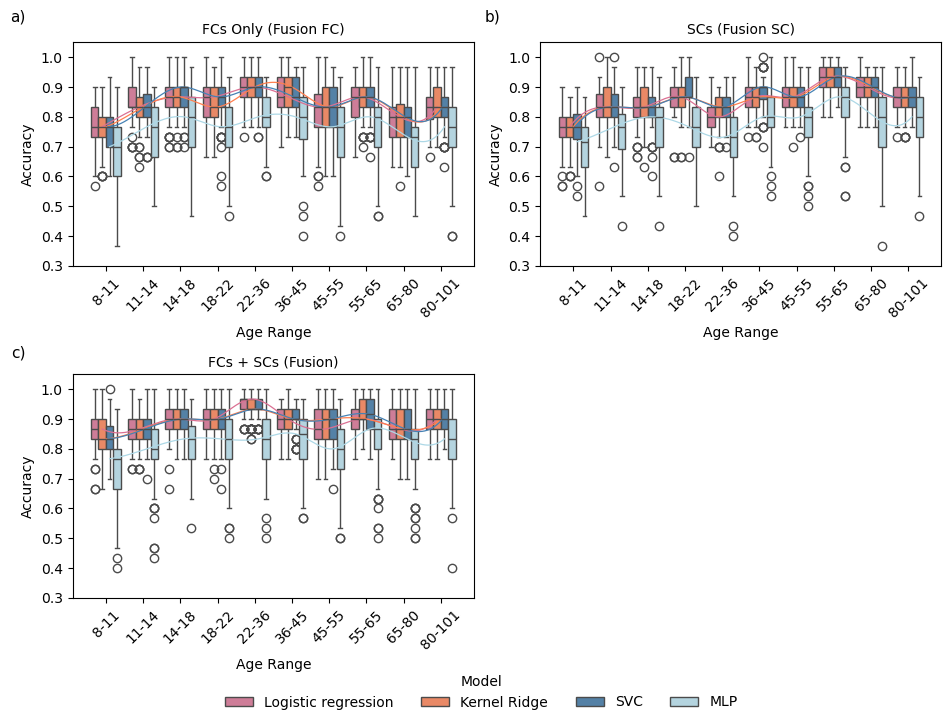

In [3]:
bin = [8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]
group_labels = ['[8,11)', '[11,14)', '[14,18)', '[18,22)', '[22,36)', '[36,45)', '[45, 55)', '[55, 65)' ,'[65, 80)', '[80,101)']
group_labels1 = ['8-11', '11-14', '14-18', '18-22', '22-36', '36-45', '45-55', '55-65', '65-80', '80-101']
kraken_compare(0.3, bin, group_labels1, (9.5, 7))